In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from model import SMuEstimator

In [3]:
from reader import read_data_preprocessed

X, y = read_data_preprocessed()

In [4]:
X = X.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [5]:
def weight(S_mu: float) -> float:
    BASE = 1
    TARGET = 3
    TARGET_S_MU = 60
    return BASE + TARGET * (S_mu / TARGET_S_MU)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=np.array([weight(S_mu) for S_mu in y_train]))
dtest = xgb.DMatrix(X_test, label=y_test, weight=np.array([weight(S_mu) for S_mu in y_test]))

In [6]:
param = {
    'max_depth': 6,
    'learning_rate': 0.05,
    'min_child_weight': 1.0,  # default = 1; larger means more conservative
    # 'subsample': 0.8,  # value below 1.0 somewhat prevents overfitting
    'objective': 'reg:squarederror',
}

epochs = 500

In [7]:
model = xgb.train(param, dtrain, num_boost_round=epochs, evals=[(dtest, 'test')], verbose_eval=5, early_stopping_rounds=15)

[0]	test-rmse:3.03019
[5]	test-rmse:2.50326
[10]	test-rmse:2.12352
[15]	test-rmse:1.85802
[20]	test-rmse:1.67584
[25]	test-rmse:1.55631
[30]	test-rmse:1.47838
[35]	test-rmse:1.42852
[40]	test-rmse:1.39791
[45]	test-rmse:1.37839
[50]	test-rmse:1.36627
[55]	test-rmse:1.35909
[60]	test-rmse:1.35436
[65]	test-rmse:1.35153
[70]	test-rmse:1.34964
[75]	test-rmse:1.34839
[80]	test-rmse:1.34753
[85]	test-rmse:1.34743
[90]	test-rmse:1.34697
[95]	test-rmse:1.34671
[100]	test-rmse:1.34645
[105]	test-rmse:1.34616
[110]	test-rmse:1.34592
[115]	test-rmse:1.34578
[120]	test-rmse:1.34569
[125]	test-rmse:1.34561
[130]	test-rmse:1.34565
[135]	test-rmse:1.34565
[140]	test-rmse:1.34554
[145]	test-rmse:1.34548
[150]	test-rmse:1.34552
[155]	test-rmse:1.34545
[160]	test-rmse:1.34539
[165]	test-rmse:1.34527
[170]	test-rmse:1.34520
[175]	test-rmse:1.34514
[180]	test-rmse:1.34511
[185]	test-rmse:1.34513
[190]	test-rmse:1.34522
[191]	test-rmse:1.34518


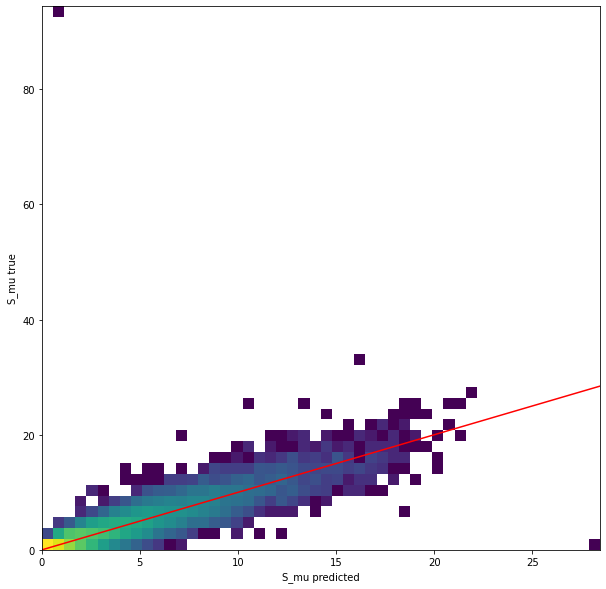

<Figure size 432x288 with 0 Axes>

In [8]:
y_pred = model.predict(dtest)
y_pred = np.maximum(y_pred, 0)
y_true = dtest.get_label()

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(10, 10))

ax.hist2d(y_pred, y_true, bins=50, norm=LogNorm())
ax.set_xlabel("S_mu predicted")
ax.set_ylabel("S_mu true")
y_max = max(y_pred.max(), y_true.max())
ax.plot([0, y_max], [0, y_max], color='red')

plt.show()

plt.savefig(f"../pics/xgboost-evaluation-S-{param['objective']}.png", bbox_inches='tight')

# Prediction error

In [9]:
N_BINS = 40
QUANTILE = 0.025
MAX_S_MU = 20

In [10]:
bin_edges = np.linspace(0, MAX_S_MU, N_BINS + 1)

# fig, axes = plt.subplots(nrows=1, ncols=N_BINS, figsize=(30, 2))

predicted = []
true_mean = []
true_lower_cl = []
true_upper_cl = []

for idx, (bin_edge_l, bin_edge_r) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    predicted_in_range_mask = np.logical_and(y_pred >= bin_edge_l, y_pred <= bin_edge_r)
    true_for_predicted_in_range = y_true[predicted_in_range_mask]
    if not true_for_predicted_in_range.size:
        continue
    # ax: plt.Axes = axes[idx]
    # ax.hist(true_for_predicted_in_range)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    predicted.append(0.5 * (bin_edge_l + bin_edge_r))
    true_mean.append(np.mean(true_for_predicted_in_range))
    true_lower_cl.append(np.quantile(true_for_predicted_in_range, QUANTILE))
    true_upper_cl.append(np.quantile(true_for_predicted_in_range, 1 - QUANTILE))

predicted = np.array(predicted)
true_mean = np.array(true_mean)
true_lower_cl = np.array(true_lower_cl)
true_upper_cl = np.array(true_upper_cl)

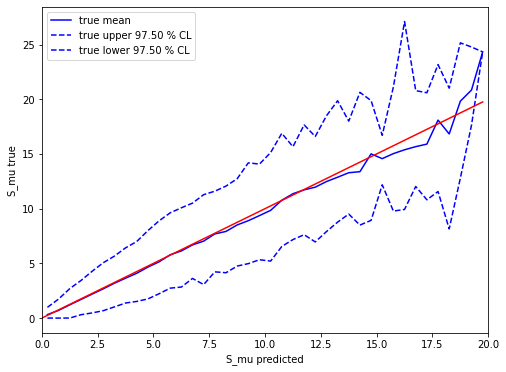

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(predicted, true_mean, 'b-', label="true mean")
cl_label = f"{100 * (1 - QUANTILE):.2f} %"
ax.plot(predicted, true_upper_cl, 'b--', label=f"true upper {cl_label} CL")
ax.plot(predicted, true_lower_cl, 'b--', label=f"true lower {cl_label} CL")
ax.plot([0, predicted[-1]], [0, predicted[-1]], color='red')
ax.set_xlim(0, MAX_S_MU)
ax.set_xlabel(r"S_mu predicted")
ax.set_ylabel(r"S_mu true")
ax.legend()

fitted a = 1.78 +/- 0.09


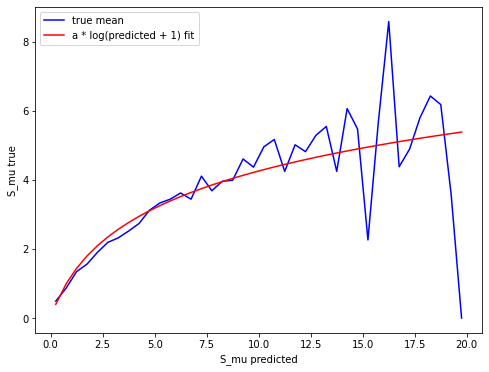

In [12]:
from scipy.optimize import curve_fit

def fun(x: float, a: float) -> float:
    return a * np.log(x + 1)

fig, ax = plt.subplots(figsize=(8, 6))

upper_cl_width = true_upper_cl - true_mean
lower_cl_width = true_mean - true_lower_cl
cl_width = 0.5 * (upper_cl_width + lower_cl_width)
ax.plot(predicted, cl_width, 'b-', label="true mean")

popt, pcov = curve_fit(fun, predicted, cl_width)
a_mean = popt[0]
a_std = np.sqrt(pcov[0][0])
ax.plot(predicted, a_mean * np.log(predicted + 1), label="a * log(predicted + 1) fit", color="red")
print(f"fitted a = {a_mean:.2f} +/- {a_std:.2f}")

ax.set_xlabel(r"S_mu predicted")
ax.set_ylabel(r"S_mu true")
ax.legend()
plt.show()

In [13]:
s_mu_estimator = SMuEstimator(
    name="iron-demo",
    xgbost_model=model,
    a_95cl=a_mean,
)
s_mu_estimator.dump()

In [14]:
# loaded_s_mu_estimator = SMuEstimator.load("iron-demo")